# Topo SparseDream Mnist

## Intro
* **Date**: 12/13/2020
* **What**: This is basically the same network as the last experiment, but I'm going to be exploring what it does specifically for mnist.  I also am going to try different lateral excitation patterns to see what gets the best results.
* **Why**: Because mnist has clear structure even though the input is small.  Ideally, I should be able to see some continuum of features, and I wasn't seeing that in the preliminary results of the last experiment.
* **Hopes**: I want to see a clear structural topology in the features.  I don't really know what that would look like, but that's what I want to see.
* **Limitations**: Because mnist digits are made up of several basic structures, I don't know if I'll see a real flow between different features.  I actually don't know what to expect.  I guess we'll see.

## Code

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tqdm import tqdm
from scipy.special import expit as sig

(train_x, _), (test_x, _) = mnist.load_data()

m_flat_tr = train_x.reshape(train_x.shape[0], -1) / 255.0
m_flat_te = test_x.reshape(test_x.shape[0], -1) / 255.0 

m_tr_len, m_len = m_flat_tr.shape

In [3]:
def draw_weights(w, Kx, Ky, s_len, fig):
    tapestry = np.zeros((s_len * Kx, s_len * Ky))
    
    w_i = 0
    for y in range(Ky):
        for x in range(Kx):
            tapestry[y * s_len: (y + 1) * s_len, x * s_len: (x + 1) * s_len] = w[w_i].reshape(s_len, s_len)
            w_i += 1
            
    plt.clf()        
    max_val = np.max(tapestry)
    im = plt.imshow(tapestry, cmap="Greys", vmax=max_val)
    fig.colorbar(im, ticks=[0, max_val])
    plt.axis("off")
    fig.canvas.draw()

## Analysis Dialog

Alright, we're going to start off with something pretty straight forward.  100 neurons, 2 nearest neighbor lateral excitation, 5 neurons firing on average.  Training on 10 epochs.

<IPython.core.display.Javascript object>


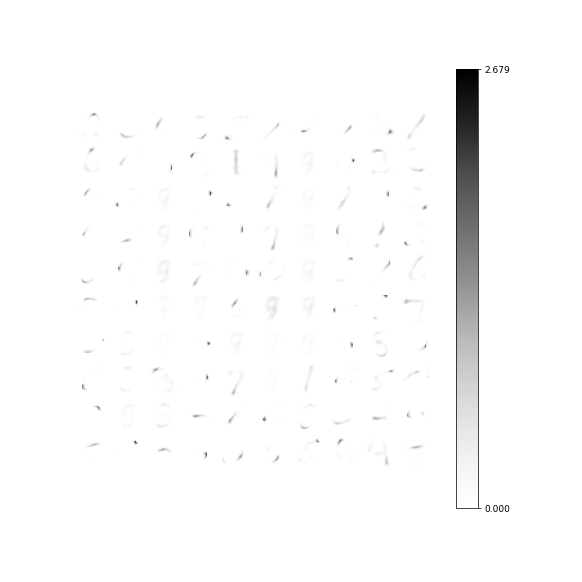

100%|█████████████████████████████████████████████████████████| 60000/60000 [00:32<00:00, 1856.85it/s]


In [3]:
%matplotlib inline
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 10
T_s = 60000
Kx = 10
Ky = 10
N = Kx * Ky
xi = 0.02
prec = 1e-10
ex = 2 # Nearest neighbor distance for lateral connections. So ex = 1 gives 8 neighbors, ex = 2 gives 24, etc

w = np.random.uniform(0.1, 1, (N, m_len))
t = np.zeros((N, 1))
sp = 0.05
gamma = 0.01

lat_ex = []

for y in range(Ky):
    for x in range(Kx):
        curr_ex = np.zeros((Ky, Kx))
        curr_ex[max(0, y - ex): min(Ky - 1, y + ex + 1), max(0, x - ex): min(Kx - 1, x + ex + 1)] = 1
        lat_ex.append(curr_ex.reshape(-1))
    
lat_ex = np.array(lat_ex)
np.fill_diagonal(lat_ex, 0)

for ep in range(Nep):
    inputs = m_flat_tr[np.random.permutation(60000)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        w_v = w @ v
        p = sig(w_v - t)
        o = sig(w_v + (lat_ex @ p) - t)
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        t += (o - sp) * gamma
        
        if i % 100 == 0:
            w = np.where(w > prec, w, 0)

    draw_weights(w, Kx, Ky, 28, fig)

You know what? I'm going to plot these as individual images, just so we can see the boxes surrounding each prototype.

<IPython.core.display.Javascript object>


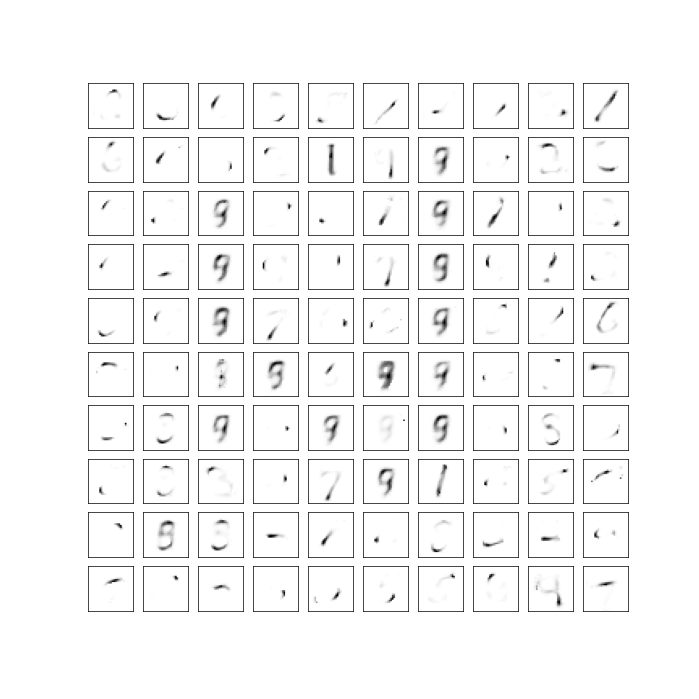

In [7]:
fig = plt.figure(figsize=(12, 12))

for x in range(Kx):
    for y in range(Ky):
        plt.subplot(Ky, Kx, 1 + x + (Kx * y))
        plt.xticks([])
        plt.yticks([])
        plt.imshow(w[x + (Kx * y)].reshape(28, 28), cmap="Greys")
plt.show()

Hmm, yeah doesn't look there's much rhyme or reason to me.  I'll do some reconstructions before I change the lateral excitation patterns.

<IPython.core.display.Javascript object>


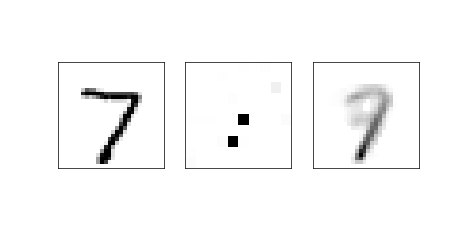

In [10]:
img_i = 0

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(10, 10), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

<IPython.core.display.Javascript object>


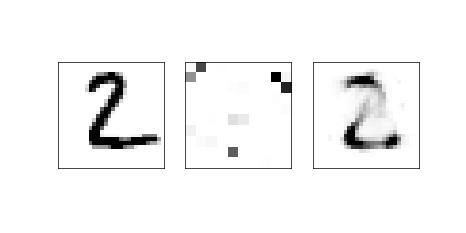

In [11]:
img_i = 1

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(10, 10), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

<IPython.core.display.Javascript object>


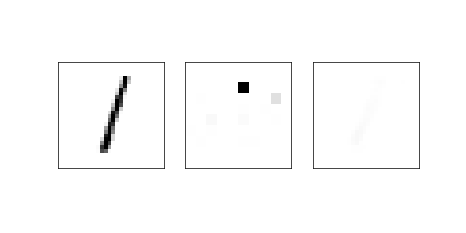

In [12]:
img_i = 2

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(10, 10), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

<IPython.core.display.Javascript object>


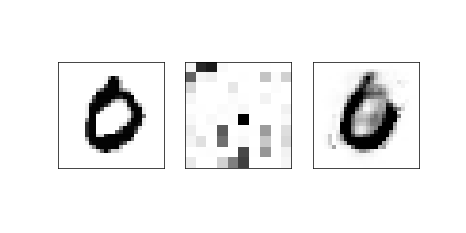

In [14]:
img_i = 3

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(10, 10), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

<IPython.core.display.Javascript object>


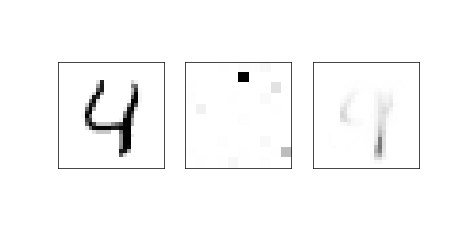

In [15]:
img_i = 4

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(10, 10), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

<IPython.core.display.Javascript object>


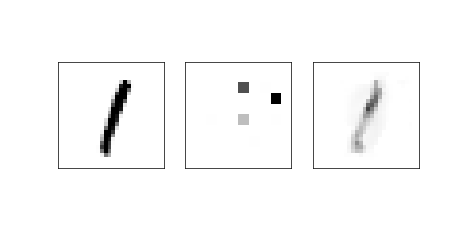

In [16]:
img_i = 5

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(10, 10), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

<IPython.core.display.Javascript object>


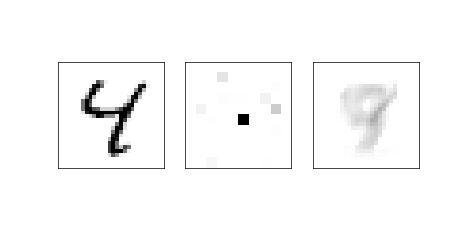

In [17]:
img_i = 6

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(10, 10), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

Wow.  On the whole, those were some absolutely sucky reconstructions.  The heatmaps were somewhat localized?  I don't know.  Before I move on, I'm going to train 400 neurons with the same constraints, and fix the sparsity so only 5 neurons fire at a time.

<IPython.core.display.Javascript object>


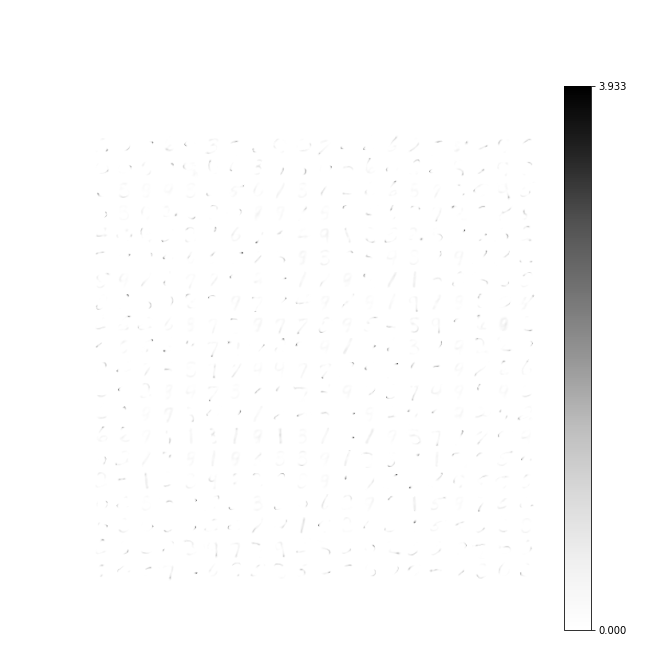

  2%|█                                                           | 360/20000 [00:01<01:43, 189.56it/s]


KeyboardInterrupt: 

In [18]:
%matplotlib inline
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 30
T_s = 20000
Kx = 20
Ky = 20
N = Kx * Ky
xi = 0.02
prec = 1e-10
ex = 2 # Nearest neighbor distance for lateral connections. So ex = 1 gives 8 neighbors, ex = 2 gives 24, etc

w = np.random.uniform(0.1, 1, (N, m_len))
t = np.zeros((N, 1))
sp = 0.0125
gamma = 0.01

lat_ex = []

for y in range(Ky):
    for x in range(Kx):
        curr_ex = np.zeros((Ky, Kx))
        curr_ex[max(0, y - ex): min(Ky - 1, y + ex + 1), max(0, x - ex): min(Kx - 1, x + ex + 1)] = 1
        lat_ex.append(curr_ex.reshape(-1))
    
lat_ex = np.array(lat_ex)
np.fill_diagonal(lat_ex, 0)

for ep in range(Nep):
    inputs = m_flat_tr[np.random.permutation(60000)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        w_v = w @ v
        p = sig(w_v - t)
        o = sig(w_v + (lat_ex @ p) - t)
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        t += (o - sp) * gamma
        
        if i % 100 == 0:
            w = np.where(w > prec, w, 0)

    draw_weights(w, Kx, Ky, 28, fig)

<IPython.core.display.Javascript object>


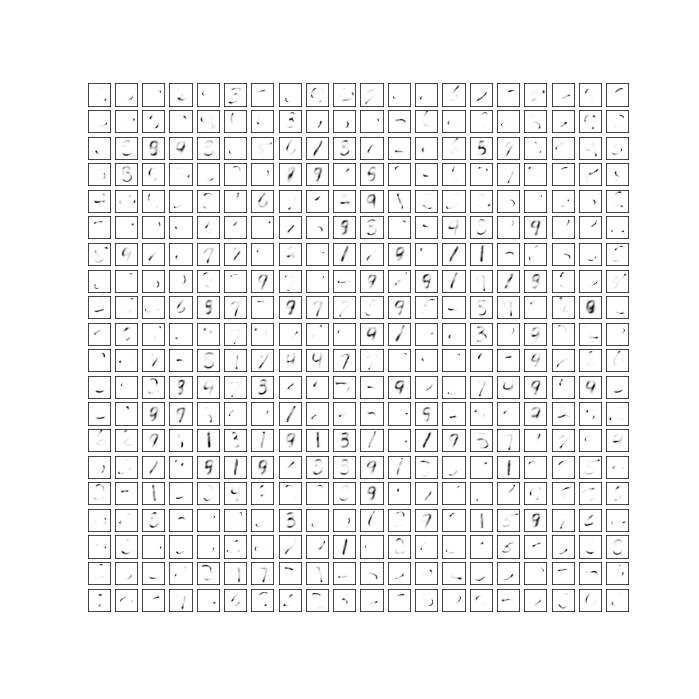

In [20]:
fig = plt.figure(figsize=(12, 12))

for x in range(Kx):
    for y in range(Ky):
        plt.subplot(Ky, Kx, 1 + x + (Kx * y))
        plt.xticks([])
        plt.yticks([])
        plt.imshow(w[x + (Kx * y)].reshape(28, 28), cmap="Greys")
plt.show()

Hmm. I'll do some reconstructions.

<IPython.core.display.Javascript object>


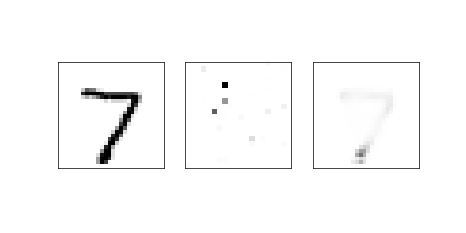

In [22]:
img_i = 0

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(20, 20), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

<IPython.core.display.Javascript object>


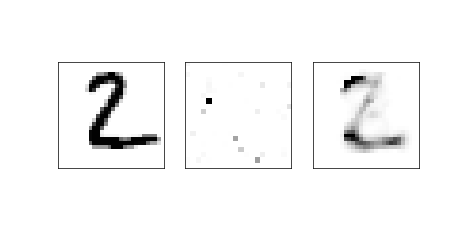

In [24]:
img_i = 1

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(Ky, Kx), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

<IPython.core.display.Javascript object>


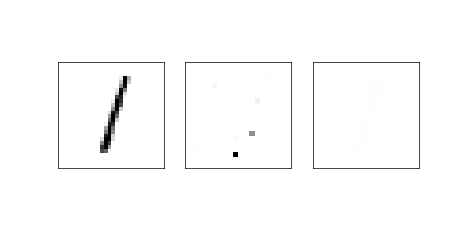

In [25]:
img_i = 2

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(Ky, Kx), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

<IPython.core.display.Javascript object>


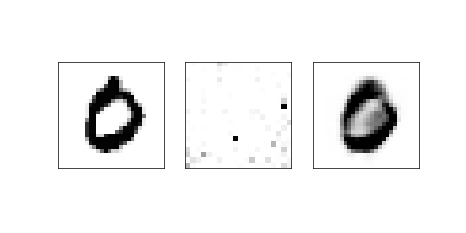

In [26]:
img_i = 3

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(Ky, Kx), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

<IPython.core.display.Javascript object>


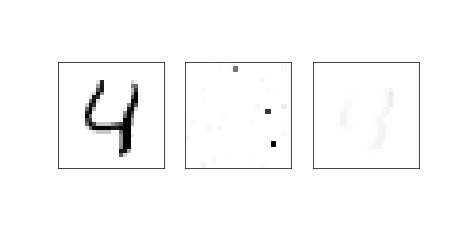

In [27]:
img_i = 4

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(Ky, Kx), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

<IPython.core.display.Javascript object>


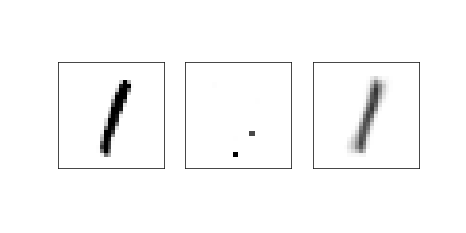

In [28]:
img_i = 5

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(Ky, Kx), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

<IPython.core.display.Javascript object>


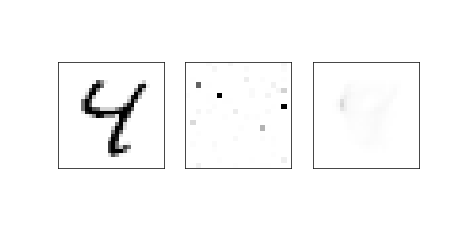

In [29]:
img_i = 6

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(Ky, Kx), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

<IPython.core.display.Javascript object>


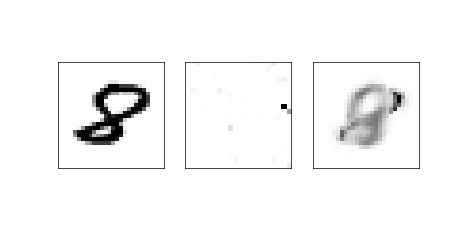

In [32]:
img_i = 61

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(Ky, Kx), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

Well, this is actually super interesting.  As you can kinda tell from the above reconstructions, the heaviest digit is the one that's most reconstructed.  Now that's fascinating.  Why?  Well, the neurons can maintain their features as long as their average sparsity is correct.  It, however, says nothing about when the neurons fire, and if they fire in sync.  Just having the sparsity term and nothing else allows all the neurons to fire at the same time.  And that, dear friends, is precisely what we *don't* want.  The whole point of sparsity is to promote only a couple neurons firing for a given input.  What we absolutely ***DO NOT*** want is for all the neurons to fire together for only a couple inputs.  That's like anti-sparsity.  It's literally exactly what we don't want.  

You know a great way to promote anti-sparsity?  You wire all the neurons together!  If you do that, then the neurons *really* want to fire together!  

So then, how do you stop this?  Well, I think probably the best thing you can do is add inhibition.  The whole point of inhibition is to keep neurons from firing at the same time.  Badabing, badaboom.

And you know what?  I think I cracked natural competition!  If you just have lateral inhibition, all sorts of nonsense can go down.  All of my failed architectures from the past two months give testament to that.  On the flip side, if you have sparsity, you're effectively guaranteeing that the neurons won't fire for every input, but it doesn't say anything about whether the neurons will fire together.  So basically if you have sparsity *and* lateral inhibition, then you effectively get competition, because the neurons aren't firing for every input, and the neurons aren't firing together.  

That's epic.  And you know what?  That's how Diehl's network worked!! He had lateral inhibition *and* the homeostasis term, which effectively acted like a sparsity factor!  So that's how he was able to naturally get competition!  Awesome!  

Ok, embarked on a minor Blackpink binge, but now we back.  Kpop is fascinating. 

Anyhoooooo, despite everything I just said, and what it suggests about this network being fundamentally flawed, there's something else I'd like to try.  I think maybe one way to get the neurons to respond more to diverse inputs would be to pump up the learning constant a bit.  That way, the neurons move their synapses faster, and thus potentially be more in touch with a more diverse feature-set.  I'm babbling.  I'm just going to do it.  Nike, bitch.

<IPython.core.display.Javascript object>


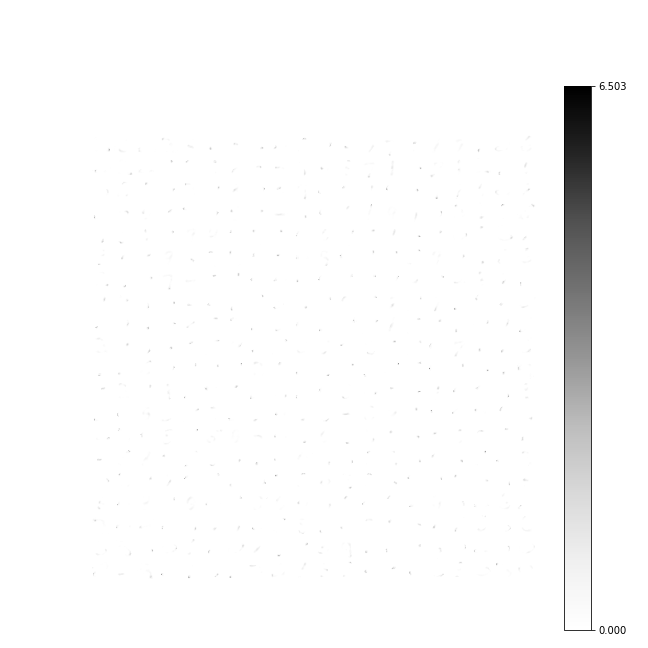

  7%|████▎                                                        | 140/2000 [00:00<00:09, 192.60it/s]


KeyboardInterrupt: 

In [3]:
%matplotlib inline
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 300
T_s = 2000
Kx = 20
Ky = 20
N = Kx * Ky
xi = 0.1
prec = 1e-10
ex = 2 # Nearest neighbor distance for lateral connections. So ex = 1 gives 8 neighbors, ex = 2 gives 24, etc

w = np.random.uniform(0.1, 1, (N, m_len))
t = np.zeros((N, 1))
sp = 0.0125
gamma = 0.01

lat_ex = []

for y in range(Ky):
    for x in range(Kx):
        curr_ex = np.zeros((Ky, Kx))
        curr_ex[max(0, y - ex): min(Ky - 1, y + ex + 1), max(0, x - ex): min(Kx - 1, x + ex + 1)] = 1
        lat_ex.append(curr_ex.reshape(-1))
    
lat_ex = np.array(lat_ex)
np.fill_diagonal(lat_ex, 0)

for ep in range(Nep):
    inputs = m_flat_tr[np.random.permutation(60000)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        w_v = w @ v
        p = sig(w_v - t)
        o = sig(w_v + (lat_ex @ p) - t)
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        t += (o - sp) * gamma
        
        if i % 100 == 0:
            w = np.where(w > prec, w, 0)

    draw_weights(w, Kx, Ky, 28, fig)

Well, that was unexpected.  Imma plot all these with self-normalized values.

<IPython.core.display.Javascript object>


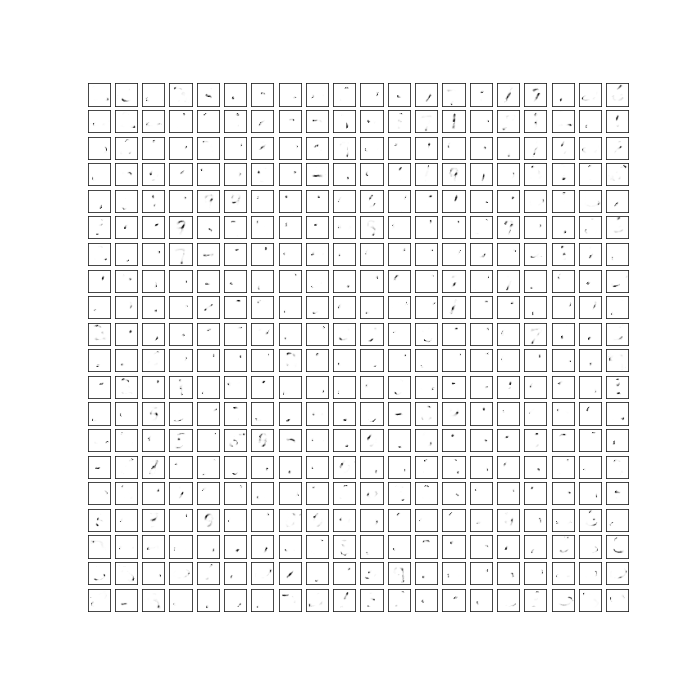

In [4]:
fig = plt.figure(figsize=(12, 12))

for x in range(Kx):
    for y in range(Ky):
        plt.subplot(Ky, Kx, 1 + x + (Kx * y))
        plt.xticks([])
        plt.yticks([])
        plt.imshow(w[x + (Kx * y)].reshape(28, 28), cmap="Greys")
plt.show()

Hmmmmmmmm.  Ok.  Whatever.  Let's do some reconstructions, and see what happens.  Also, I should mention that the neurons settled on these features before even one epoch.  

Ok, reconstructions.

<IPython.core.display.Javascript object>


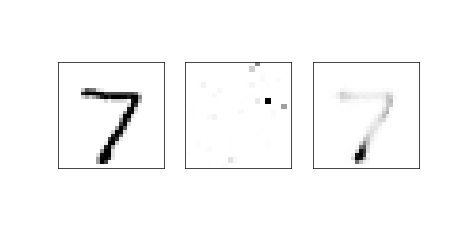

In [5]:
img_i = 0

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(20, 20), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

<IPython.core.display.Javascript object>


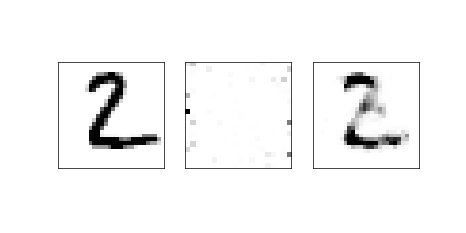

In [6]:
img_i = 1

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(Ky, Kx), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

<IPython.core.display.Javascript object>


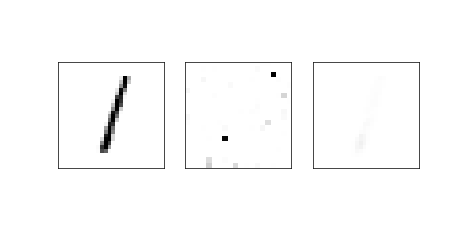

In [7]:
img_i = 2

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(Ky, Kx), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

<IPython.core.display.Javascript object>


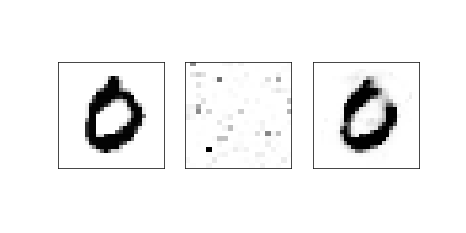

In [8]:
img_i = 3

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(Ky, Kx), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

<IPython.core.display.Javascript object>


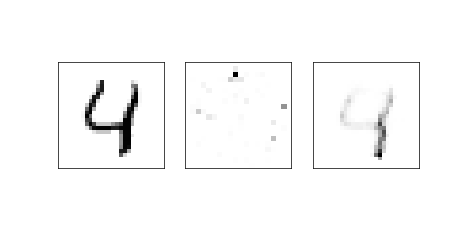

In [9]:
img_i = 4

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(Ky, Kx), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

<IPython.core.display.Javascript object>


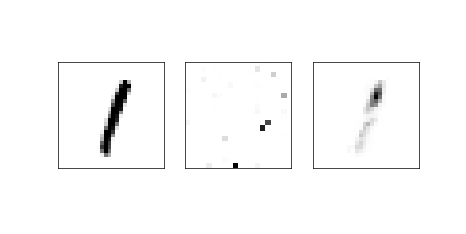

In [10]:
img_i = 5

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(Ky, Kx), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

<IPython.core.display.Javascript object>


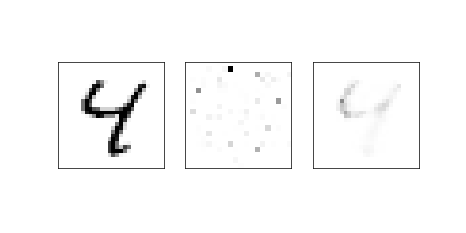

In [11]:
img_i = 6

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(Ky, Kx), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

<IPython.core.display.Javascript object>


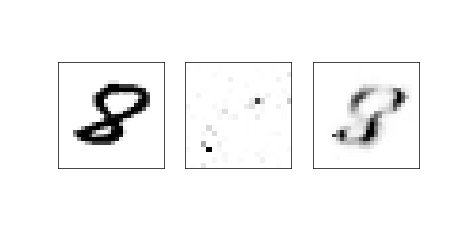

In [12]:
img_i = 61

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(Ky, Kx), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

Well, the neurons certainly aren't localized.  Hmm, I'm going to boost `gamma` and see what happens.

<IPython.core.display.Javascript object>


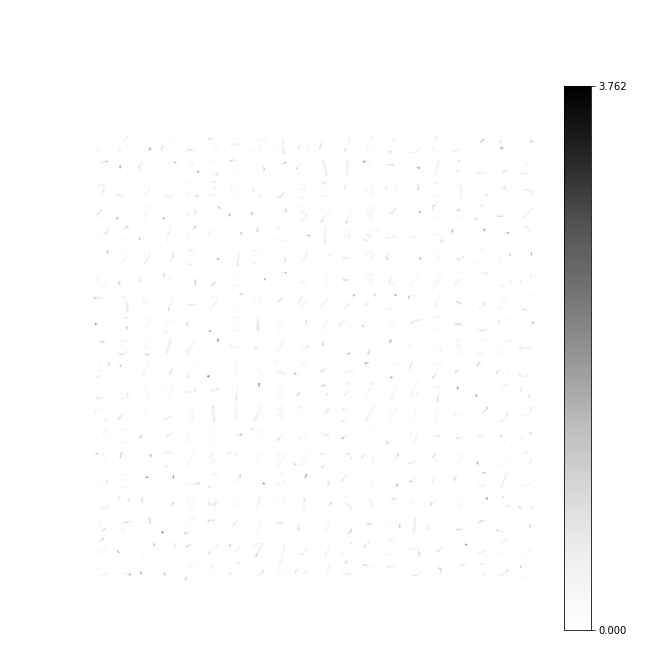

  1%|▍                                                             | 13/2000 [00:00<00:15, 125.35it/s]


KeyboardInterrupt: 

In [13]:
%matplotlib inline
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 300
T_s = 2000
Kx = 20
Ky = 20
N = Kx * Ky
xi = 0.1
prec = 1e-10
ex = 2 # Nearest neighbor distance for lateral connections. So ex = 1 gives 8 neighbors, ex = 2 gives 24, etc

w = np.random.uniform(0.1, 1, (N, m_len))
t = np.zeros((N, 1))
sp = 0.0125
gamma = 0.1

lat_ex = []

for y in range(Ky):
    for x in range(Kx):
        curr_ex = np.zeros((Ky, Kx))
        curr_ex[max(0, y - ex): min(Ky - 1, y + ex + 1), max(0, x - ex): min(Kx - 1, x + ex + 1)] = 1
        lat_ex.append(curr_ex.reshape(-1))
    
lat_ex = np.array(lat_ex)
np.fill_diagonal(lat_ex, 0)

for ep in range(Nep):
    inputs = m_flat_tr[np.random.permutation(60000)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        w_v = w @ v
        p = sig(w_v - t)
        o = sig(w_v + (lat_ex @ p) - t)
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        t += (o - sp) * gamma
        
        if i % 100 == 0:
            w = np.where(w > prec, w, 0)

    draw_weights(w, Kx, Ky, 28, fig)

Yeah, that's more what I'm talking about.  That's what I like to see.  I'm going to run the standard analysis, then I'll discuss.

<IPython.core.display.Javascript object>


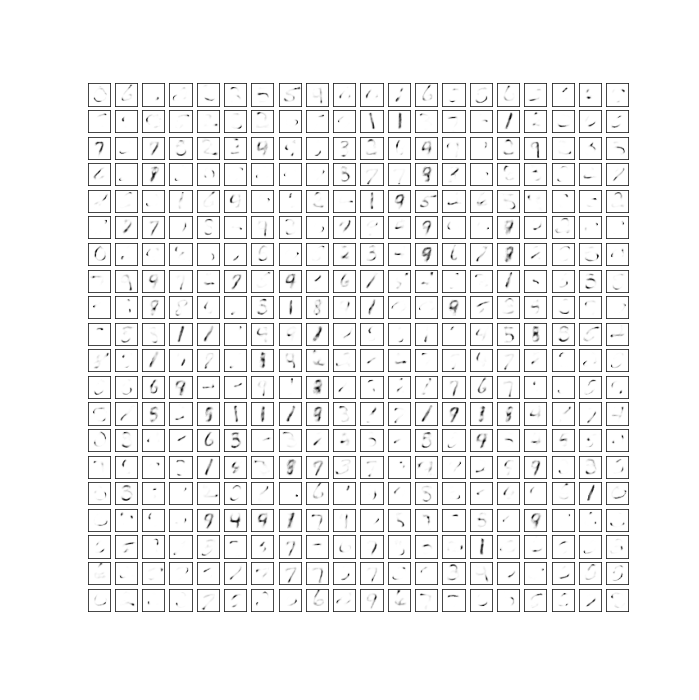

In [14]:
fig = plt.figure(figsize=(12, 12))

for x in range(Kx):
    for y in range(Ky):
        plt.subplot(Ky, Kx, 1 + x + (Kx * y))
        plt.xticks([])
        plt.yticks([])
        plt.imshow(w[x + (Kx * y)].reshape(28, 28), cmap="Greys")
plt.show()

<IPython.core.display.Javascript object>


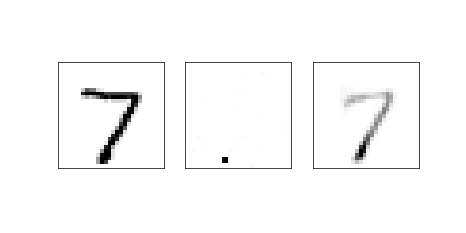

In [15]:
img_i = 0

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(20, 20), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

<IPython.core.display.Javascript object>


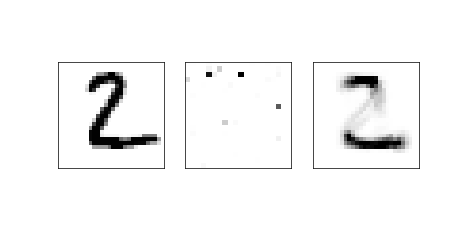

In [16]:
img_i = 1

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(Ky, Kx), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

<IPython.core.display.Javascript object>


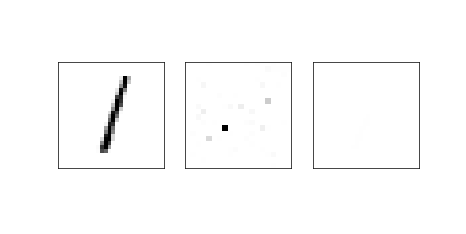

In [17]:
img_i = 2

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(Ky, Kx), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

<IPython.core.display.Javascript object>


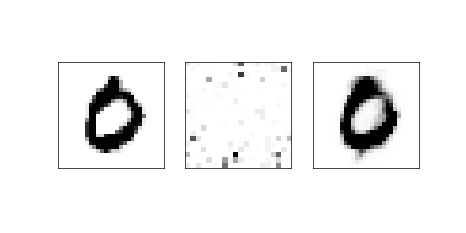

In [18]:
img_i = 3

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(Ky, Kx), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

<IPython.core.display.Javascript object>


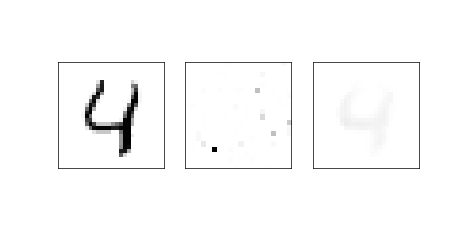

In [19]:
img_i = 4

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(Ky, Kx), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

<IPython.core.display.Javascript object>


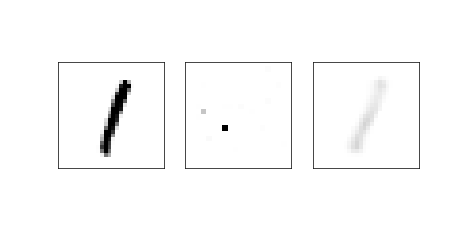

In [20]:
img_i = 5

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(Ky, Kx), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

<IPython.core.display.Javascript object>


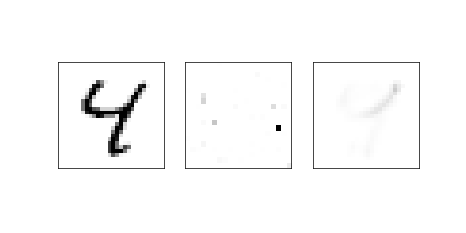

In [21]:
img_i = 6

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(Ky, Kx), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

<IPython.core.display.Javascript object>


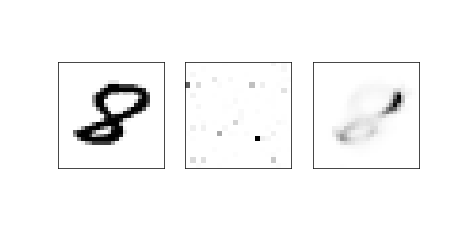

In [22]:
img_i = 61

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(Ky, Kx), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

Wow those reconstructions are like super garbage.  It appears that the neurons are trying to learn full prototypes.  That should stop.  I'm going to try something new.  I'm going to keep $\gamma$ big, and make $\xi$ small.  That might prove to be an interesting combination.  

Depending on what that does, I might also decrease the sparsity constant.  Ok, let's try this first.

<IPython.core.display.Javascript object>


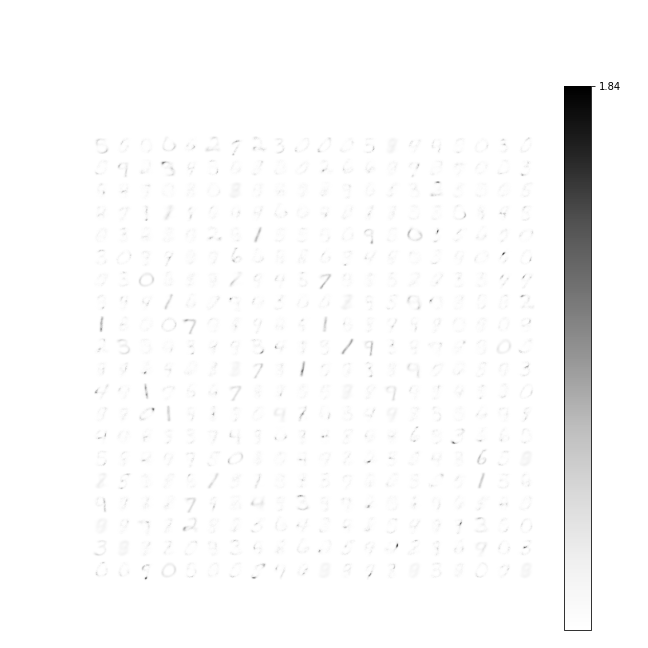

 86%|███████████████████████████████████████████████████▊        | 1729/2000 [00:08<00:01, 192.04it/s]


KeyboardInterrupt: 

In [23]:
%matplotlib inline
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 300
T_s = 2000
Kx = 20
Ky = 20
N = Kx * Ky
xi = 0.01
prec = 1e-10
ex = 2 # Nearest neighbor distance for lateral connections. So ex = 1 gives 8 neighbors, ex = 2 gives 24, etc

w = np.random.uniform(0.1, 1, (N, m_len))
t = np.zeros((N, 1))
sp = 0.0125
gamma = 0.1

lat_ex = []

for y in range(Ky):
    for x in range(Kx):
        curr_ex = np.zeros((Ky, Kx))
        curr_ex[max(0, y - ex): min(Ky - 1, y + ex + 1), max(0, x - ex): min(Kx - 1, x + ex + 1)] = 1
        lat_ex.append(curr_ex.reshape(-1))
    
lat_ex = np.array(lat_ex)
np.fill_diagonal(lat_ex, 0)

for ep in range(Nep):
    inputs = m_flat_tr[np.random.permutation(60000)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        w_v = w @ v
        p = sig(w_v - t)
        o = sig(w_v + (lat_ex @ p) - t)
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        t += (o - sp) * gamma
        
        if i % 100 == 0:
            w = np.where(w > prec, w, 0)

    draw_weights(w, Kx, Ky, 28, fig)

Yeah, I'm not a fan.  I'm going to boost both `gamma` and `xi`, and see if we converge faster.

<IPython.core.display.Javascript object>


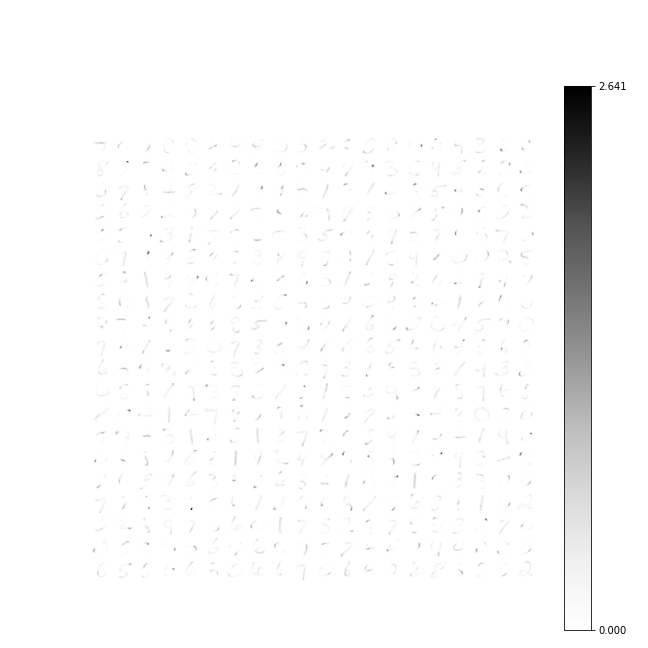

 22%|█████████████▍                                               | 440/2000 [00:02<00:07, 198.27it/s]


KeyboardInterrupt: 

In [24]:
%matplotlib inline
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 300
T_s = 2000
Kx = 20
Ky = 20
N = Kx * Ky
xi = 0.1
prec = 1e-10
ex = 2 # Nearest neighbor distance for lateral connections. So ex = 1 gives 8 neighbors, ex = 2 gives 24, etc

w = np.random.uniform(0.1, 1, (N, m_len))
t = np.zeros((N, 1))
sp = 0.0125
gamma = 1

lat_ex = []

for y in range(Ky):
    for x in range(Kx):
        curr_ex = np.zeros((Ky, Kx))
        curr_ex[max(0, y - ex): min(Ky - 1, y + ex + 1), max(0, x - ex): min(Kx - 1, x + ex + 1)] = 1
        lat_ex.append(curr_ex.reshape(-1))
    
lat_ex = np.array(lat_ex)
np.fill_diagonal(lat_ex, 0)

for ep in range(Nep):
    inputs = m_flat_tr[np.random.permutation(60000)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        w_v = w @ v
        p = sig(w_v - t)
        o = sig(w_v + (lat_ex @ p) - t)
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        t += (o - sp) * gamma
        
        if i % 100 == 0:
            w = np.where(w > prec, w, 0)

    draw_weights(w, Kx, Ky, 28, fig)

Ok, yeah it's learning stuff faster for sure, but I think this trick would only work for shuffled data.  I'm going to do the reconstructions, and then I'm going to pump up `sp`.

<IPython.core.display.Javascript object>


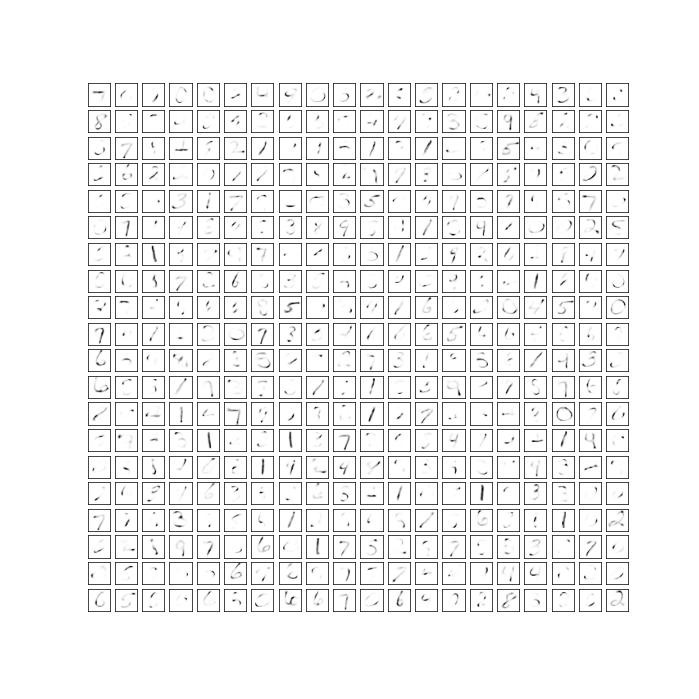

In [25]:
fig = plt.figure(figsize=(12, 12))

for x in range(Kx):
    for y in range(Ky):
        plt.subplot(Ky, Kx, 1 + x + (Kx * y))
        plt.xticks([])
        plt.yticks([])
        plt.imshow(w[x + (Kx * y)].reshape(28, 28), cmap="Greys")
plt.show()

<IPython.core.display.Javascript object>


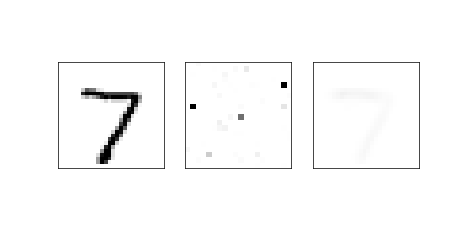

In [34]:
img_i = 0

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(20, 20), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

<IPython.core.display.Javascript object>


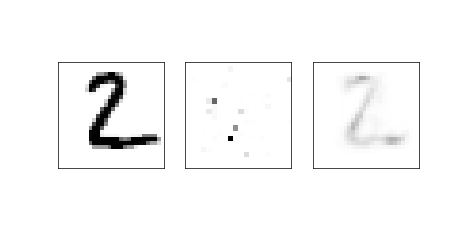

In [27]:
img_i = 1

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(Ky, Kx), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

<IPython.core.display.Javascript object>


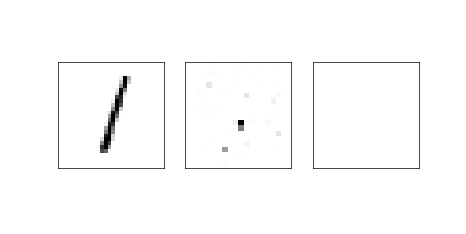

In [28]:
img_i = 2

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(Ky, Kx), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

<IPython.core.display.Javascript object>


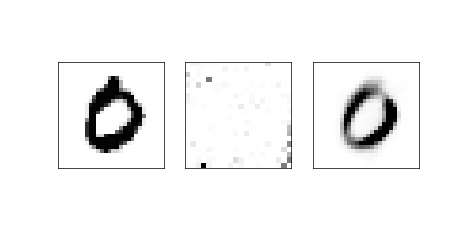

In [29]:
img_i = 3

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(Ky, Kx), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

<IPython.core.display.Javascript object>


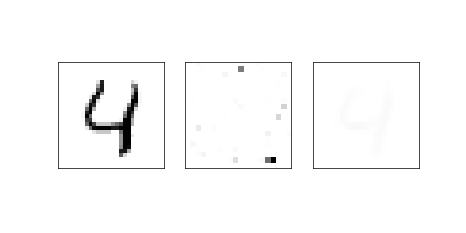

In [30]:
img_i = 4

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(Ky, Kx), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

<IPython.core.display.Javascript object>


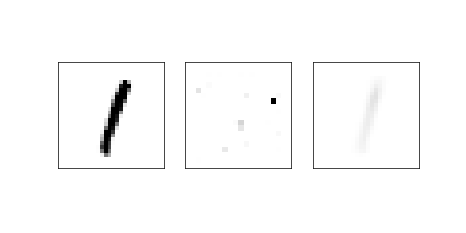

In [31]:
img_i = 5

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(Ky, Kx), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

<IPython.core.display.Javascript object>


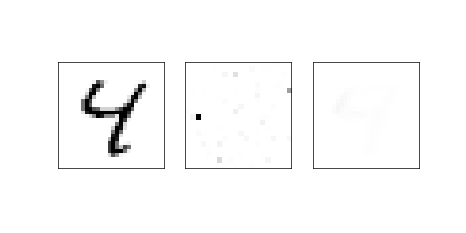

In [32]:
img_i = 6

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(Ky, Kx), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

<IPython.core.display.Javascript object>


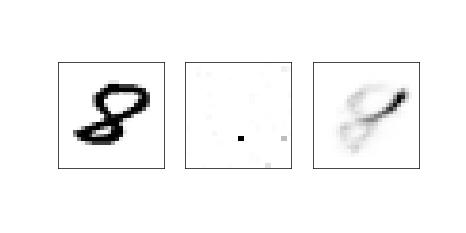

In [33]:
img_i = 61

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(Ky, Kx), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

Yup.  Those reconstructions are trash.  Let's pump up the sparsity, and then call this one quits.

<IPython.core.display.Javascript object>


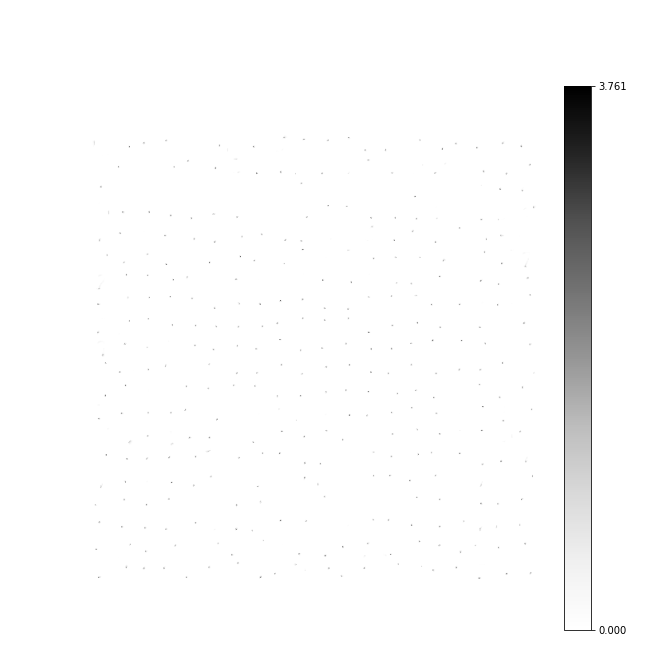

  5%|██▉                                                           | 93/2000 [00:00<00:10, 174.68it/s]


KeyboardInterrupt: 

In [35]:
%matplotlib inline
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 300
T_s = 2000
Kx = 20
Ky = 20
N = Kx * Ky
xi = 0.1
prec = 1e-10
ex = 2 # Nearest neighbor distance for lateral connections. So ex = 1 gives 8 neighbors, ex = 2 gives 24, etc

w = np.random.uniform(0.1, 1, (N, m_len))
t = np.zeros((N, 1))
sp = 0.05
gamma = 1

lat_ex = []

for y in range(Ky):
    for x in range(Kx):
        curr_ex = np.zeros((Ky, Kx))
        curr_ex[max(0, y - ex): min(Ky - 1, y + ex + 1), max(0, x - ex): min(Kx - 1, x + ex + 1)] = 1
        lat_ex.append(curr_ex.reshape(-1))
    
lat_ex = np.array(lat_ex)
np.fill_diagonal(lat_ex, 0)

for ep in range(Nep):
    inputs = m_flat_tr[np.random.permutation(60000)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        w_v = w @ v
        p = sig(w_v - t)
        o = sig(w_v + (lat_ex @ p) - t)
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        t += (o - sp) * gamma
        
        if i % 100 == 0:
            w = np.where(w > prec, w, 0)

    draw_weights(w, Kx, Ky, 28, fig)

<IPython.core.display.Javascript object>


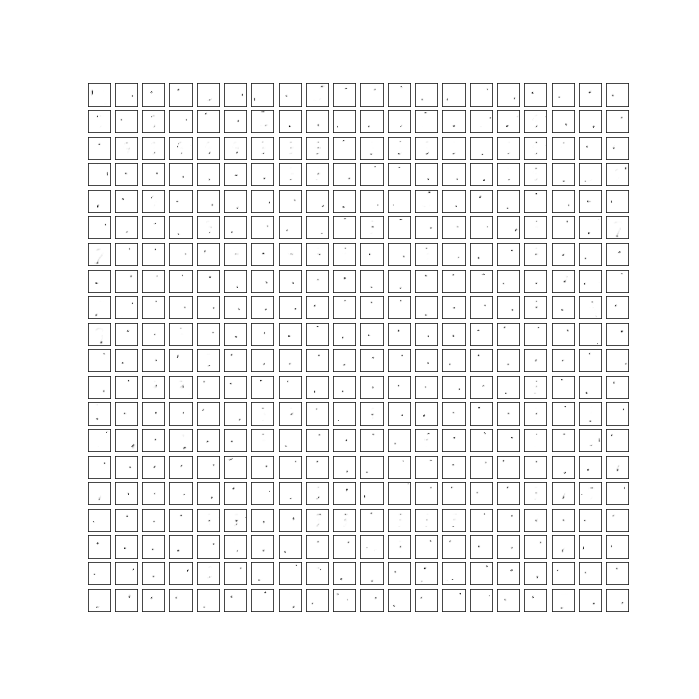

In [36]:
fig = plt.figure(figsize=(12, 12))

for x in range(Kx):
    for y in range(Ky):
        plt.subplot(Ky, Kx, 1 + x + (Kx * y))
        plt.xticks([])
        plt.yticks([])
        plt.imshow(w[x + (Kx * y)].reshape(28, 28), cmap="Greys")
plt.show()

<IPython.core.display.Javascript object>


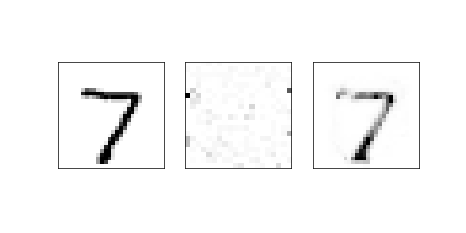

In [37]:
img_i = 0

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(20, 20), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

<IPython.core.display.Javascript object>


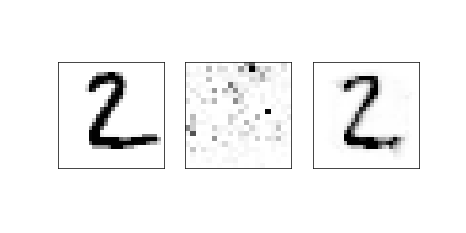

In [38]:
img_i = 1

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(Ky, Kx), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

<IPython.core.display.Javascript object>


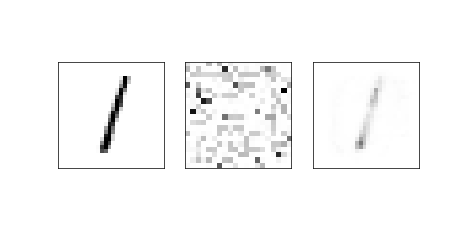

In [39]:
img_i = 2

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(Ky, Kx), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

<IPython.core.display.Javascript object>


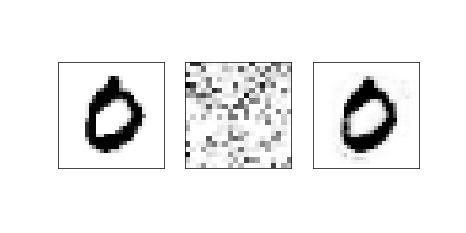

In [40]:
img_i = 3

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(Ky, Kx), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

<IPython.core.display.Javascript object>


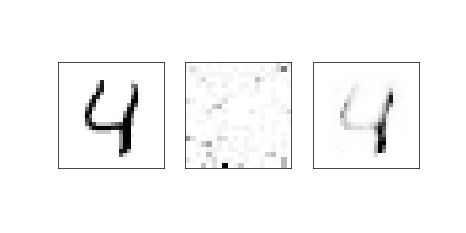

In [41]:
img_i = 4

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(Ky, Kx), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

<IPython.core.display.Javascript object>


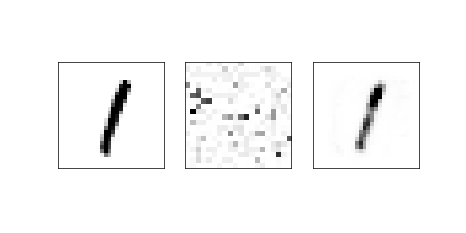

In [42]:
img_i = 5

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(Ky, Kx), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

<IPython.core.display.Javascript object>


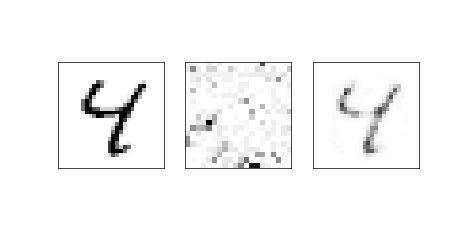

In [43]:
img_i = 6

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(Ky, Kx), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

<IPython.core.display.Javascript object>


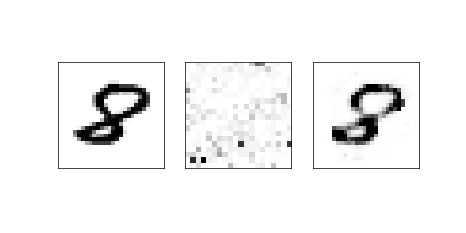

In [44]:
img_i = 61

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(Ky, Kx), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

Hmm, I need something between those two.  I think maybe `sp = 0.03`. Also something interesting happened that time.  The features on the edges converged faster,

<IPython.core.display.Javascript object>


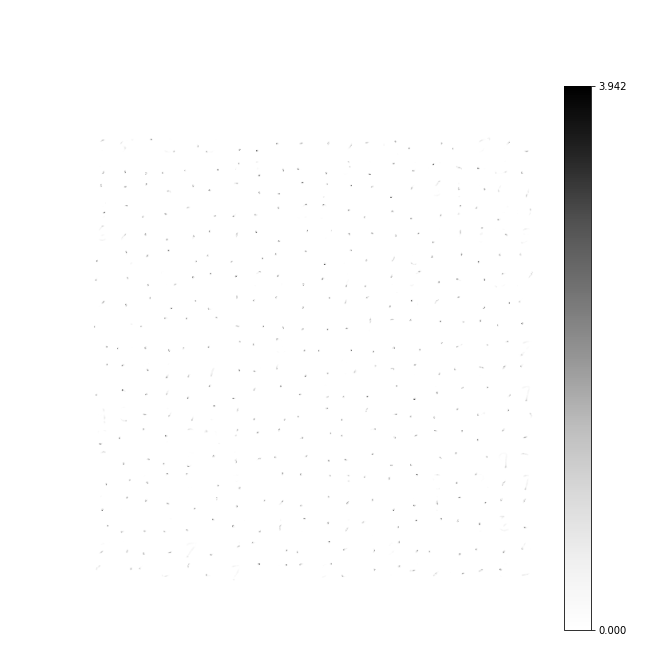

 15%|█████▋                                | 298/2000 [00:01<00:08, 198.43it/s]


KeyboardInterrupt: 

In [4]:
%matplotlib inline
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 300
T_s = 2000
Kx = 20
Ky = 20
N = Kx * Ky
xi = 0.1
prec = 1e-10
ex = 2 # Nearest neighbor distance for lateral connections. So ex = 1 gives 8 neighbors, ex = 2 gives 24, etc

w = np.random.uniform(0.1, 1, (N, m_len))
t = np.zeros((N, 1))
sp = 0.03
gamma = 1

lat_ex = []

for y in range(Ky):
    for x in range(Kx):
        curr_ex = np.zeros((Ky, Kx))
        curr_ex[max(0, y - ex): min(Ky - 1, y + ex + 1), max(0, x - ex): min(Kx - 1, x + ex + 1)] = 1
        lat_ex.append(curr_ex.reshape(-1))
    
lat_ex = np.array(lat_ex)
np.fill_diagonal(lat_ex, 0)

for ep in range(Nep):
    inputs = m_flat_tr[np.random.permutation(60000)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        w_v = w @ v
        p = sig(w_v - t)
        o = sig(w_v + (lat_ex @ p) - t)
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        t += (o - sp) * gamma
        
        if i % 100 == 0:
            w = np.where(w > prec, w, 0)

    draw_weights(w, Kx, Ky, 28, fig)

That's no good.  `sp = 0.02` for sure.

<IPython.core.display.Javascript object>


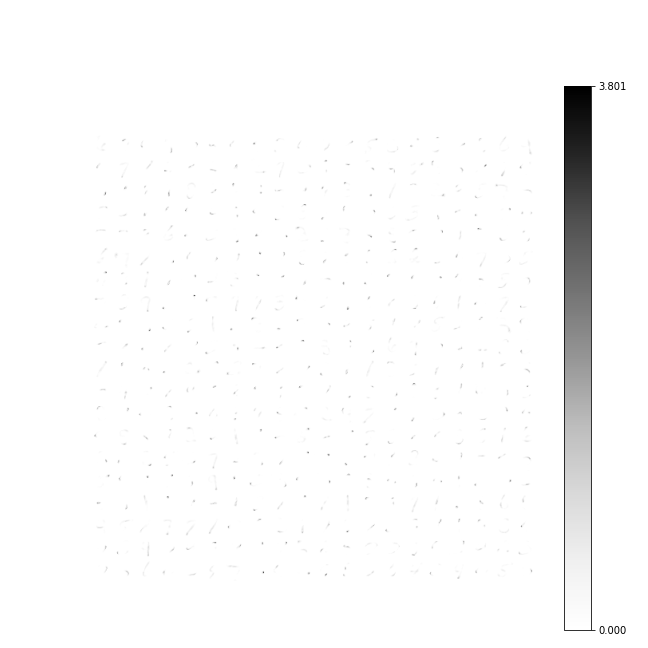

 32%|████████████▎                         | 649/2000 [00:03<00:06, 195.03it/s]

KeyboardInterrupt: 

In [6]:
%matplotlib inline
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 300
T_s = 2000
Kx = 20
Ky = 20
N = Kx * Ky
xi = 0.1
prec = 1e-10
ex = 2 # Nearest neighbor distance for lateral connections. So ex = 1 gives 8 neighbors, ex = 2 gives 24, etc

w = np.random.uniform(0.1, 1, (N, m_len))
t = np.zeros((N, 1))
sp = 0.02
gamma = 1

lat_ex = []

for y in range(Ky):
    for x in range(Kx):
        curr_ex = np.zeros((Ky, Kx))
        curr_ex[max(0, y - ex): min(Ky - 1, y + ex + 1), max(0, x - ex): min(Kx - 1, x + ex + 1)] = 1
        lat_ex.append(curr_ex.reshape(-1))
    
lat_ex = np.array(lat_ex)
np.fill_diagonal(lat_ex, 0)

for ep in range(Nep):
    inputs = m_flat_tr[np.random.permutation(60000)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        w_v = w @ v
        p = sig(w_v - t)
        o = sig(w_v + (lat_ex @ p) - t)
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        t += (o - sp) * gamma
        
        if i % 100 == 0:
            w = np.where(w > prec, w, 0)

    draw_weights(w, Kx, Ky, 28, fig)

<IPython.core.display.Javascript object>


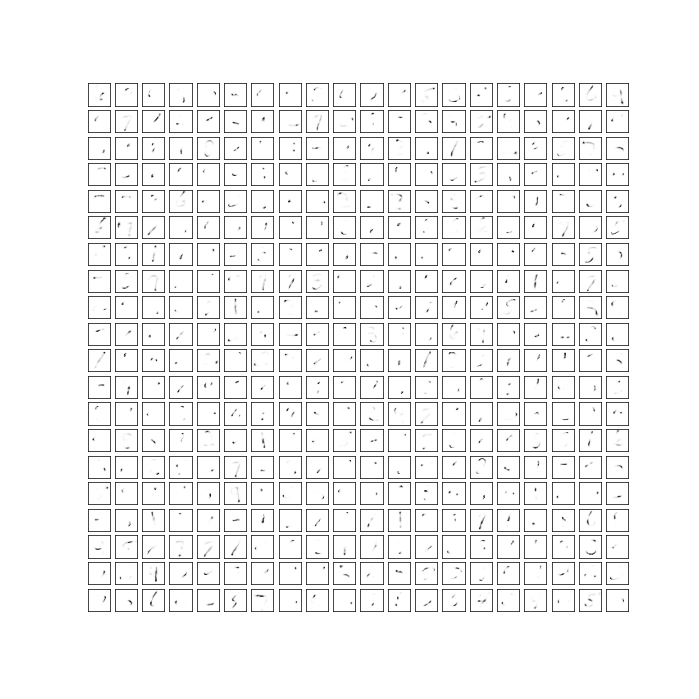

In [7]:
fig = plt.figure(figsize=(12, 12))

for x in range(Kx):
    for y in range(Ky):
        plt.subplot(Ky, Kx, 1 + x + (Kx * y))
        plt.xticks([])
        plt.yticks([])
        plt.imshow(w[x + (Kx * y)].reshape(28, 28), cmap="Greys")
plt.show()

<IPython.core.display.Javascript object>


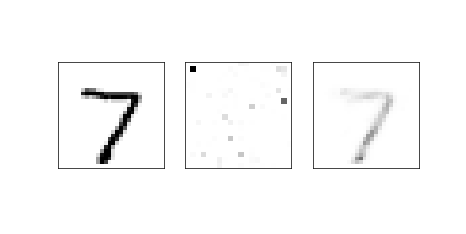

In [8]:
img_i = 0

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(20, 20), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

<IPython.core.display.Javascript object>


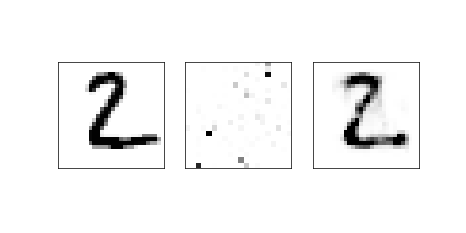

In [9]:
img_i = 1

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(Ky, Kx), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

<IPython.core.display.Javascript object>


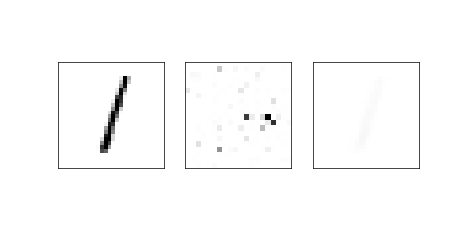

In [10]:
img_i = 2

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(Ky, Kx), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

<IPython.core.display.Javascript object>


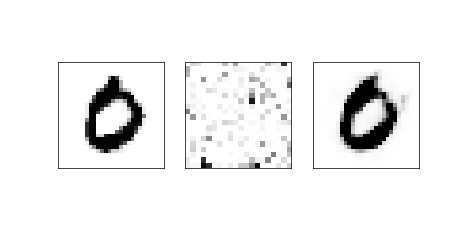

In [11]:
img_i = 3

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(Ky, Kx), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

<IPython.core.display.Javascript object>


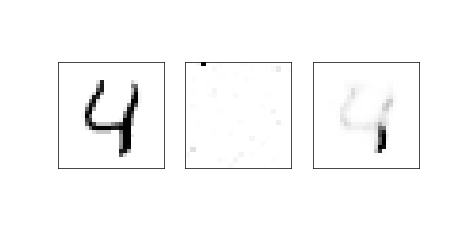

In [12]:
img_i = 4

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(Ky, Kx), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

<IPython.core.display.Javascript object>


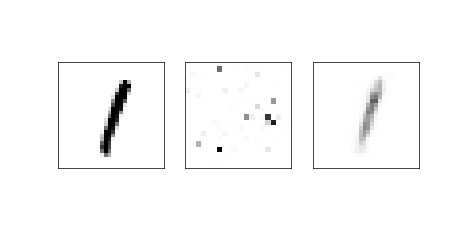

In [13]:
img_i = 5

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(Ky, Kx), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

<IPython.core.display.Javascript object>


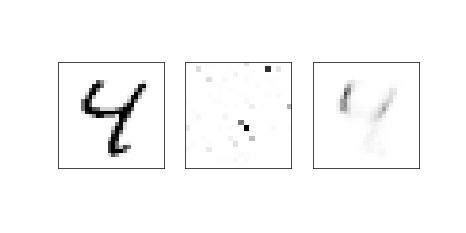

In [14]:
img_i = 6

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(Ky, Kx), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

<IPython.core.display.Javascript object>


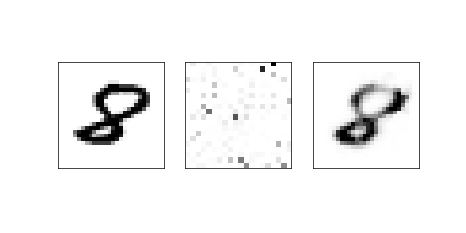

In [15]:
img_i = 61

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(Ky, Kx), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

That's pretty compelling, actually.  That kinda actually looks like the templates Yubei's sparse coding network learned at the first layer of the stack sparse manifold transform.  

Even though there's perhaps more I could do without inhibition, I think it's pretty evident that lateral inhibition is incredibly important for a variety of reasons.  With that said, getting lateral inhibition working in this network I think is priority numero uno.

## Conclusions

Basically, I think the biggest takeaway from this experiment is that sparsity + inhibition = competition.  And competition is the juice that we need.  Also, just having blanket lateral excitation actually isn't the sauce.  I'm trying to create manifolds, so I think some of the neurons next to each other should be alternatives to the given input. Basically like

--- 0 ---  
--- * ---  
--- 0 ---  

Where * is the neuron, 0 is inhibition, and --- are excitatory connections.  So the manifold of possibilities is one-dimensional, and the topological connections anchoring a given input are in the 2 dimensions surrounding the neuron.  This is super interesting.  This way, I might be able to learn actual topologies without time-series data.  

So I might actually be able to create full-fledged manifolds just with one layer.  We'll see.  Anyway, the sp + in = comp is really the big takeaway.

I've also been listening to Blackpink for like an hour and a half, so I'm not sure if what I'm writing is at all coherent.  Man that stuff slaps.

## Next steps

Figure out inhibition.  Organize the network into topologies.  Take names.  Learn actual structure.  Boom.  